In [9]:
import zipfile
kor_eng = zipfile.ZipFile('./kor-eng.zip')
kor_eng.extractall()
kor_eng.close()

In [11]:
import pandas as pd
temp = pd.read_table('kor.txt', names=['Eng', 'Kor', 'license'])
temp.shape

(5749, 3)

In [12]:
temp.head()

,Eng,Kor,license
0,Go.,가.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,안녕.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Run!,뛰어!,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
3,Run.,뛰어.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,Who?,누구?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [15]:
eng_sent = temp['Eng'].tolist()
kor_sent = temp['Kor'].tolist()

print(eng_sent[1000])
print(kor_sent[1000])

My cat is black.
내 고양이는 검은색 고양이야.


### 데이터 준비
- 0. 단어와 구두점 사이 공백 만들기
- 1. sos와 eos
- 2. tokenizing, idx_seq, padding

#### 0. 단어와 구두점 사이 공백 만들기

In [19]:
import unicodedata
import re
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')
def eng_preprocessor(sent):
    sent = unicode_to_ascii(sent.lower())
    
    # 단어와 구두점 사이에 공백을 만든다.
    sent = re.sub(r"([?.!,'¿])", r" \1 ", sent)
    
    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?']+", r" ", sent)
    
    sent = re.sub(r"\s+", " ", sent)
    
    return sent

def kor_preprocessor(sent):
    sent = unicode_to_ascii(sent.lower())
    
    # 단어와 구두점 사이에 공백을 만든다.
    sent = re.sub(r"([?.!,'¿])", r" \1 ", sent)
    sent = re.sub(r"\s+", " ", sent)
    return sent

In [20]:
eng_preprocessor("I'm a just a poor boy.")

"i ' m a just a poor boy . "

In [21]:
eng_sent = [ eng_preprocessor(sent) for sent in eng_sent]
kor_sent = [ kor_preprocessor(sent) for sent in kor_sent]

print(eng_sent[1000])
print(kor_sent[1000])

my cat is black . 
내 고양이는 검은색 고양이야 . 


#### 1. sos와 eos
- 1. sos: start of speech
- 2. eos: end of speech

In [22]:
# 한국어 문장 전 후에 <sos>와 <eos>를 추가한다.
kor_sent = [f'<sos> {kor} <eos>' for kor in kor_sent]
kor_sent[1000] 

'<sos> 내 고양이는 검은색 고양이야 .  <eos>'

#### 2. Tokenizing, idx_seq, padding

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
# Tokenizing : 한국어는 lower=False
tokenizer_en = Tokenizer(filters="", lower=True)
tokenizer_en.fit_on_texts(eng_sent)
tokenizer_kor = Tokenizer(filters="", lower=False)
tokenizer_kor.fit_on_texts(kor_sent)

In [ ]:
tokenizer_en.word_index
"""
{'.': 1,
 'i': 2,
 "'": 3,
 'tom': 4,
"""

tokenizer_kor.word_index
"""
'<sos>': 1,
'<eos>': 2,
 '.': 3,
 '?': 4,
 """

In [52]:
len(tokenizer_en.word_index), len(tokenizer_kor.word_index)

(3076, 7843)

In [25]:
# Index Sequence
eng_seq = tokenizer_en.texts_to_sequences(eng_sent)
kor_seq = tokenizer_kor.texts_to_sequences(kor_sent)

print(eng_seq[1000])
print(kor_seq[1000])

[22, 136, 9, 558, 1]
[1, 14, 259, 1111, 1089, 3, 2]


In [27]:
# padding: 최대 문장 길이에 맞춰지도록 한다.
eng_pad = pad_sequences(eng_seq)
kor_pad = pad_sequences(kor_seq)

print(eng_pad.shape)
print(kor_pad.shape)

(5749, 102)
(5749, 97)


In [36]:
eng_seq[1000]

[22, 136, 9, 558, 1]

In [42]:
pad_sequences(eng_seq)[1000] #문장의 최대길이가 97이므로 0으로 모두 채운것임.

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  22, 136,   9, 558,   1])

In [28]:
# tokenizer에서 0 index가 구성되어있지 않지만,
# pad_sequence에서 pad의 의미로 0을 사용하고 있기 때문에, 전체 사이즈를 구할 때 +1을 해준다.

eng_vocab_size = len(tokenizer_en.word_index) + 1
kor_vocab_size = len(tokenizer_kor.word_index) + 1
print("영어 단어 집합의 크기: {:d}\n한국어 단어 집합의 크기: {:d}".format(eng_vocab_size, kor_vocab_size))

영어 단어 집합의 크기: 3077
한국어 단어 집합의 크기: 7844


- pad_sequence를 통해 tokenizer_한 en, kor에 각각 0값이 추가됨
- 0값은 padding의 의미임
- 따라서, 0값은 제외하고 생각해준다.

#### 모델링

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GRU, Dense

In [66]:
tf.keras.backend.clear_session()

# 한국어 단어 집합의 크기: 7844, (5749, 97) # 영어단어 집합의 크기, 데이터갯수, 최대문장길이
# 영어 단어 집합의 크기: 3077, (5749, 102) # 한국어단어 집합의 크기, 데이터갯수, 최대문장길이

# Encoder
enc_X = Input(shape=[eng_pad.shape[1]]) # 102(영어 최대 문장 길이)
# 모든 임베딩 레이어는 128개 차원으로 구성  #단어집합(=토큰들) 임베딩
enc_E = Embedding(eng_vocab_size, 128)(enc_X) # 토큰수, 차원수
# 인코더 GRU, 히든스테이트 512로 구성
enc_S_full, enc_S = GRU(512, return_sequences=True, return_state=True)(enc_E)


# Decoder
dec_X = Input(shape=[kor_pad.shape[1]-1]) # decoder의 인풋은 마지막 <eos>를 뗀다.
# 모든 임베딩 레이어는 128개의 차원으로 구성 # 단어집합(=토큰들) 임베딩
dec_E = Embedding(kor_vocab_size, 128)(dec_X) # 토큰수, 차원수
# 디코더 GRU, 히든스테이트 512로 구성
dec_H = GRU(512, return_sequences=True)(dec_E, initial_state=enc_S) #initial_state에는 encoder의 가장 마지막 값이 들어감
dec_H = Dense(512, activation='swish')(dec_H)
dec_Y = Dense(kor_vocab_size, activation='softmax')(dec_H)

#Model
model = tf.keras.models.Model([enc_X, dec_X], dec_Y)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()
 



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 102, 128)     393856      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 96, 128)      1004032     input_2[0][0]                    
______________________________________________________________________________________________

In [67]:
kor_pad[:, 0] # <sos> 부분은 제거해야함.

array([0, 0, 0, ..., 0, 0, 1])

In [69]:
# decoder의 인풋은 마지막 <eos>를 뗀다.
# decoder의 아웃풋은 학습시에 처음의 <sos>를 뗀다.

history = model.fit([eng_pad, kor_pad[:, :-1]], kor_pad[:,1:], shuffle=True, 
          batch_size=128, epochs=10)

Epoch 1/10
45/45 [==============================] - 5s 112ms/step - loss: 0.3476 - accuracy: 0.9474
Epoch 2/10
45/45 [==============================] - 5s 111ms/step - loss: 0.3375 - accuracy: 0.9477
Epoch 3/10
45/45 [==============================] - 5s 108ms/step - loss: 0.3290 - accuracy: 0.9479
Epoch 4/10
45/45 [==============================] - 5s 108ms/step - loss: 0.3214 - accuracy: 0.9480
Epoch 5/10
45/45 [==============================] - 5s 108ms/step - loss: 0.3130 - accuracy: 0.9484
Epoch 6/10
45/45 [==============================] - 5s 108ms/step - loss: 0.3077 - accuracy: 0.9486
Epoch 7/10
45/45 [==============================] - 5s 109ms/step - loss: 0.2990 - accuracy: 0.9489
Epoch 8/10
45/45 [==============================] - 5s 110ms/step - loss: 0.2927 - accuracy: 0.9491
Epoch 9/10
45/45 [==============================] - 5s 109ms/step - loss: 0.2837 - accuracy: 0.9495
Epoch 10/10
45/45 [==============================] - 5s 109ms/step - loss: 0.2776 - accuracy: 0.9498

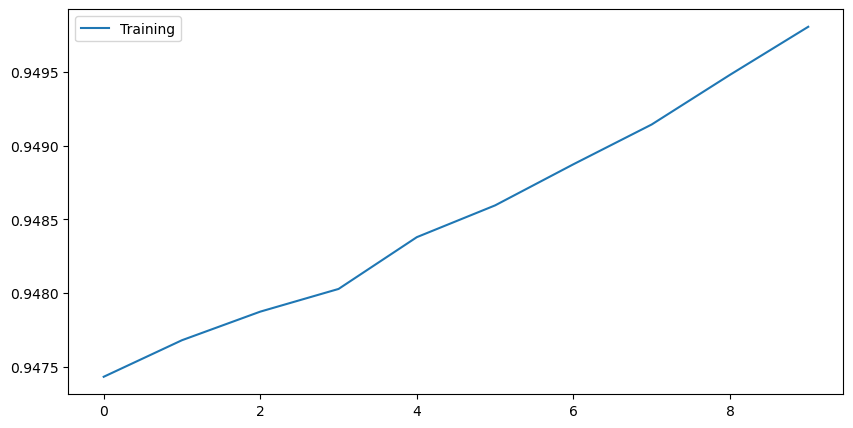

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.legend(['Training'], loc=0)
plt.show()
